<h1 align=center> PROGRAMMING ASSIGNMENT 1 </h1>
<h2 align=center> CANNY EDGE DETECTION </h2>

In [1]:
import os
# PLEASE NOTE: I am using opencv for just reading in the image
# ALL the other code was self-written with some help from stackoverflow 
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# CHECKING to see if the input image is present in the CWD
os.listdir('.')

['Images',
 'EE6132-PA1-EE17B146.ipynb',
 'PA1-EE17B146.zip',
 'CannyAssignment.pdf',
 'EE6132_Assignment_1_Report.pdf',
 '.ipynb_checkpoints',
 'clown.jpeg']

In [3]:
# READING IN THE INPUT IMAGE
img = cv2.imread('./clown.jpeg',1)
img.shape

(168, 300, 3)

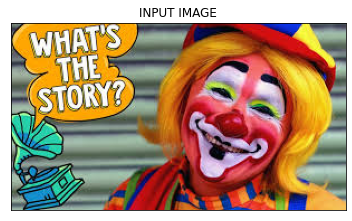

In [4]:
# PLOTTING THE INPUT IMAGE WITH MATPLOTLIB
plt.imshow(img[..., ::-1])
plt.title('INPUT IMAGE'), plt.xticks([]), plt.yticks([])
plt.show()

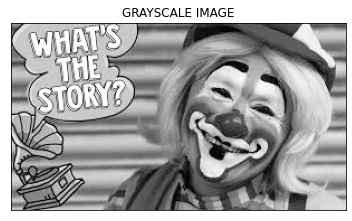

In [5]:
# CONVERTING THE IMAGE TO GRAYSCALE
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(grey, cmap='Greys_r')
# DISPLAYING THE GRAYSCALED IMAGE
plt.title('Grayscale image'.upper()), plt.xticks([]), plt.yticks([])
plt.show()

<h2 align=center> GAUSSIAN BLURRING THE IMAGE </h2>

- It is preferable to gaussian blur the input image to smoothen it and suppress the noise. We use a  5 × 5 Gaussian Kernel with sigma = 1.5 to smoothen the image.

- **NOTE**: The gaussian kernel that is used is plotted below for clarity.

In [6]:
def normal_density(x, mu, sd):
    """
        Function to calculate density using the Univariate Normal Distribution.

        INPUTS : Takes in an array, the mean(mu) and the stddev(sigma) of the Normal Distribution.
        OUTPUT : Returns the gaussian density of the input array.

    """
    return 1/(np.sqrt(2*np.pi)*sd)*pow(np.e, (-pow((x-mu)/sd, 2)/2))


def get_Kernel(k_size=5, sigma=1.5, verbose=False):
    """
        Function to return a gaussian filter of given size and stddev(sigma).

        INPUTS : Takes in the kernel size(int), the gaussian stddev sigma(float) 
                 and a verbose flag to toggle the display of the gaussian filter.
        OUTPUT : Returns the gaussian kernel of given shape.

    """
    # Creating a 1D Kernel for calculating gaussian density
    kernel = np.array(range(-(k_size//2), k_size//2+1))
    # Calculating the gaussian density of the kernel
    kernel = normal_density(kernel, 0, sigma)
    # Taking the outer product of the 1D-Kernel to get a 2D-Kernel
    kernel = np.outer(kernel, kernel)
    # Normalizing the 2D-kernel
    kernel /= kernel.max()
    # Checking for verbose flag
    if verbose:
        # Plotting the 2D-kernel for clarity (if verbose is set)
        plt.imshow(kernel, cmap='Greys_r')
        plt.title(f"{k_size}x{k_size} GAUSSIAN FILTER"), plt.show()

    # Returning the gaussian kernel of shape (k_size, k_size)
    return kernel


def gaussian_Blur(img, k_size=5, sigma=1.5, verbose=False):
    """
        Function to return the gaussian blurred image given the image, filter size and stddev(sigma).

        INPUTS : Takes in a grayscale image(2D-Array), k_size(int) the kernel size, 
                 sigma(float), the gaussian stddev and a verbose flag.

        OUTPUT : Returns the gaussian blurred image.
    """
    # Checking to see if the image is in Grayscale
    if len(img.shape) != 2:
        raise AttributeError(
            "The input image should be in 2-D grayscale format")

    # Getting the kernel
    kernel = get_Kernel(k_size, sigma, verbose)

    # Storing image shape in h and w
    h, w = img.shape

    # Getting the padding width from kernel size
    n_pad = (k_size-1)//2

    # Creating a blank image with padding
    blur = np.zeros((h+n_pad*2, w+n_pad*2))
    # Storing the image in blur for convolution
    blur[n_pad:h+n_pad, n_pad:w+n_pad] = img

    from scipy.ndimage import convolve

    # Returning the gaussian blur
    return convolve(blur, kernel)

- **NOTE:** The kernel size is set to 5 and sigma to 1.5 by default. For using different values, pass them as arguments to the gaussian_Blur() function.

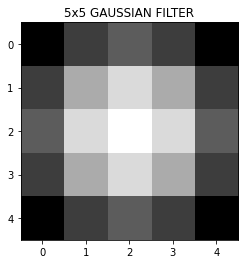

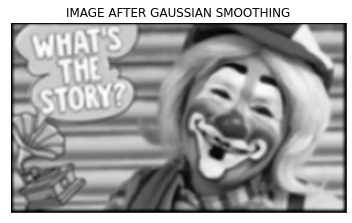

In [69]:
# Calling the blurring function
blur = gaussian_Blur(grey, verbose=True)

# DISPLAYING THE IMAGE AFTER SMOOTHING AND DE-NOISING
plt.imshow(blur, cmap='Greys_r')
plt.title('IMAGE AFTER GAUSSIAN SMOOTHING'), plt.xticks([]), plt.yticks([])
plt.show()

<h2 align=center> APPLYING THE Gx and Gy SOBEL OPERATORS </h2>

In [8]:
def sobel(img, thresh=100):
    """
        Function to apply the Gx and Gy sobel operators to the de-noised image to get the filtered Sx and Sy outputs. 
        The gradient magnitude and angle images are also returned. 

        INPUTS: Takes in an input image(Grayscale image/2D-Array) and a threshold(to check false triggers).
        OUTPUTS: The Sx and Sx filtered images, and the gradient magnitude and angle images(4 in total) as 2D-Arrays.

    """

    # Storing image shape for later use
    h, w = img.shape

    # Padding the input image for applying the Gx and Gy filters
    padded = np.zeros((h+2, w+2))
    padded[1:-1, 1:-1] = img

    # Creating four blank images to store the outputs
    sobel_x = np.zeros((h, w))      # Sx
    sobel_y = np.zeros((h, w))      # Sy

    grad_mag = np.zeros((h, w))     # Gradient magnitude
    grad_angle = np.zeros((h, w))   # Gradient angle

    # Storing the Gx and Gy sobel filters
    Gx = [[-1, 0, 1],
          [-2, 0, 2],
          [-1, 0, 1]]

    Gy = [[1, 2, 1],
          [0, 0, 0],
          [-1, -2, -1]]

    # Iterating though the image pizels (We do not need to compute anything for the padding)
    for i in range(1, h+1):
        for j in range(1, w+1):

            # Getting the X and Y gradients from Gx and Gy
            # np.multiply is used for element-wise multiplication
            grad_x = np.sum(np.multiply(Gx, padded[i-1:i+2, j-1:j+2]))
            grad_y = np.sum(np.multiply(Gy, padded[i-1:i+2, j-1:j+2]))

            # Getting the gradient magnitude
            mag = np.sqrt(grad_x**2+grad_y**2)

            # Getting the gradient angle
            angle = None
            if mag < thresh:
                # Applying the threshold
                mag = 0
                """
                    Setting the angle to 180 when gradient magnitude is less than threshold for ease 
                    of handling in later stages (WILL be explained).
                """ 
                angle = 180
                # Note that arctan() gives output in radians in the range(-pi/2,pi/2) 
                
            elif grad_x == 0:
                # If the x gradient is zero and y gradient is not(since mag>thresh)
                # then setting the angle to 90 degrees to avoid divide-by-zero error.
                angle = 90
            else:
                """
                    Note that arctan() only gives output in range(-90,90) degrees and I want angles 
                    to be in the range(0,180) for viualizing the angle image,so adding I am adding 90 
                    to the output of arctan().
                    
                    Radians to Degrees conversion is also applied.
                """ 
                angle = ((np.arctan(grad_y/grad_x)/np.pi)*180)+90

                # If the angle is more than 157.5 (135+22.5) degrees, then the angle is set to zero
                # since the edge gradient is vertical anyways.
                if angle > 157.5:
                    angle = 0

            # Storing X and Y gradients in Sx and Sy
            sobel_x[i-1][j-1] = grad_x
            sobel_y[i-1][j-1] = grad_y

            # Storing the computed magnitude and angle
            grad_mag[i-1][j-1] = mag
            grad_angle[i-1][j-1] = angle

    # Normalizing the magnitude image for ease of calculation
    # Note that the minimum gradient magnitude is close to zero
    grad_mag = grad_mag/grad_mag.max()
    
    # Rounding off the angle image for visualization sake
    grad_angle = np.array(np.round(grad_angle), dtype=int)

    # Returning the required output images
    return sobel_x, sobel_y, grad_mag, grad_angle

In [9]:
# Getting Sx, Sy, Gradient Magnitude and Gradient angle images
sobel_x, sobel_y, grad_mag, grad_angle = sobel(blur, thresh=1100)

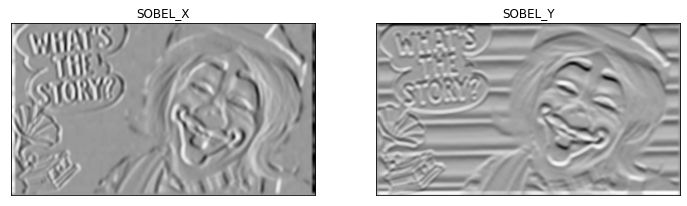

In [10]:
# PLOTTING THE Sx and Sy IMAGES
plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
plt.imshow(sobel_x, cmap='Greys_r'), plt.xticks([]), plt.yticks([])
plt.title('SOBEL_X')

plt.subplot(1, 2, 2)
plt.imshow(sobel_y, cmap='Greys_r'), plt.xticks([]), plt.yticks([])
plt.title('SOBEL_Y')
plt.show()

- From the outputs above, we can clearly observe that the **Gx filter identifies vertical edges** and the **Gy filter identifies horizontal edges**

In [11]:
def generate_Color_Gradient(C1, C2, N):
    """
        Function to generate colormaps for visualizing sobel gradient angle.

        INPUTS: Two color extrema and the number of colors in between.
        OUTPUT: The colormap from color1 to color2 with "N" colors in between.   

    """

    # Computing the color differences in C1 and C2
    color_diff = [(c2-c1)/(N-1) for c1, c2 in zip(C1, C2)]

    # Generating the colormap
    cmap = [[int(c+i*dc) for c, dc in zip(C1, color_diff)] for i in range(N)]

    # Returning the required colormap
    return cmap


def generate_Graded_Image(img):
        
    """
        Function to generate the color image for visualizing sobel gradient angle
        
        INPUTS: The input gradient angle image.
        OUTPUT: The color image for visualizing sobel gradient angle.

    """
    
    # Generating two colormaps for angles from 0-90 and 91-179
    # As we need all three RGB channels for the image
    cmap1 = generate_Color_Gradient((255, 0, 0), (0, 255, 0), 90)
    cmap2 = generate_Color_Gradient((0, 255, 0), (0, 0, 255), 90)

    """ 
        Note that the areas where the gradient magnitude is zero is marked with angle = 180, 
        so stacking [0,0,0] in the end allows us to set all pixels below threshold to zero
        
        This was done becauase the angle where magnitude = 0 cannot not be set to zero because 
        theta = 0 => horizontal edge,so I had to create a workaround like this.
    """
    cmap = np.vstack((np.array(cmap1 + cmap2), [0, 0, 0]))

    # Getting the colored angle image from the colormap
    angle_clr = np.array(cmap[img], dtype=int)

    # Returning the colored angle image
    return angle_clr

In [12]:
# GENERATING THE COLORED ANGLE IMAGE
clr_img = generate_Graded_Image(grad_angle)

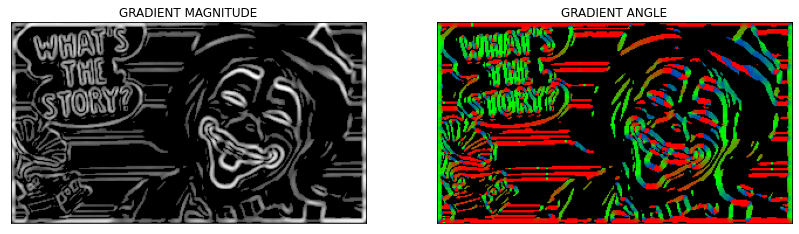

In [13]:
# DISPLAYING THE GRADIENT IMAGES (MAGNITUDE AND ANGLE)

# Setting the figsize to (14,10) for better clarity
plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
plt.imshow(grad_mag, cmap='Greys_r')
plt.xticks([]), plt.yticks([]), plt.title('GRADIENT MAGNITUDE')
plt.subplot(1, 2, 2)
plt.imshow(clr_img)
plt.xticks([]), plt.yticks([]), plt.title('GRADIENT ANGLE')
plt.show()

<h2 align=center> CANNY EDGE DETECTION </h2>

The following operations are performed using the function in the below cell. Note that the image is already de-noised so we can directly used the smoothed image. 
- First, the sobel operator is applied to get the gradient magnitude and angle images.
- Second, non-maximum suppression is applied to thin multi-pixel wide "ridges" down to single pixel width.
- Third, a single thresholding operation is applied to remove low magnitude edges and give a sharp edge output.

In [62]:
def chk_greater(x, y, z):
    """
        Function returns 1 if x is greater than y and z else 0.

        INPUTS: x,y and z
        OUTPUT: 0/1
    """
    if x > y and x > z:
        return 1
    else:
        return 0


def get_Angle_Bin(angle):
    """
        Function to check which bin the given angle belongs.

        BIN 0: If angle is 180, i.e. the gradient magnitude = 0
        BIN 1: If angle is in the interval [0,22.5]
        BIN 2: If angle is in the interval (22.5,67.45]
        BIN 3: If angle is in the interval (67.5,112.5]
        BIN 4: If angle is in the interval (112.5,157.5]

        Note that the angle was set to zero if angle > 157.5 before.

        INPUT: The angle.
        OUTPUT: The bin of the angle.

    """
    if angle == 180:
        return 0
    elif 0 <= angle <= 22.5:
        return 1
    elif 22.5 < angle <= 67.5:
        return 2
    elif 67.5 < angle <= 112.5:
        return 3
    elif 112.5 < angle <= 157.5:
        return 4
    else:
        # Just in case
        raise ValueError(f"Invalid angle value = {angle}")


def canny(img, thresh=None):
    """
        Function to apply the sobel operator, non-maximum suppression and a single thresholding operation
        to a given input grayscale image.

        INPUTS: A grayscale image(img) and the threshold(thresh).
        OUTPUTS: The magnitude image after non-maximum suppression and the final output image.
    """

    # Getting the sobel gradient magnitude and angle images
    # NOTE: We do not need the Sx and Sy images for Canny Edge Detection.
    _, _, grad_mag, grad_angle = sobel(img, thresh=0)

    # Storing image shape
    h, w = grad_mag.shape

    # Computing the median of the gradient magnitude image to use as threshold
    import statistics
    # Use the median if thresh is not provided as input
    if thresh is None:
        # NOTE : I found that setting the thresh to mean worked better, so I'm using it.
        # Feel free to use median to check its output.
        # thresh = statistics.median(grad_mag.ravel()) 
        
        # NOTE : The np.ndarray.ravel() method outputs an 1-D array containing all the values in a n-D array
        thresh = statistics.mean(grad_mag.ravel())
        
    # Creating a copy of the gradient magnitude image for canny output
    canny = grad_mag.copy()

    # Initializing two placeholder variables
    tmp1, tmp2 = 0, 0
    
    # Iterating through the interior of the image
    for i in range(1, h-1):
        for j in range(1, w-1):
            
            """ NON_MAXIMUM SUPPRESSION """
            
            # Getting the BIN of the angle for non-maximum supression
            ang_bin = get_Angle_Bin(grad_angle[i, j])

            # Ignoring the pixel if angle is in BIN 0.
            if ang_bin:
                if ang_bin == 1:
                    # BIN = 1, so supressing the pixels along y-axis
                    tmp1, tmp2 = grad_mag[i-1, j], grad_mag[i+1, j]
                elif ang_bin == 2:
                    # BIN = 2, so supressing the pixels along x-y=c
                    tmp1, tmp2 = grad_mag[i-1, j-1], grad_mag[i+1, j+1]
                elif ang_bin == 3:
                    # BIN = 3, so supressing the pixels along x-axis
                    tmp1, tmp2 = grad_mag[i, j-1], grad_mag[i, j+1]
                elif ang_bin == 4:
                    # BIN = 4, so supressing the pixels along x+y=c
                    tmp1, tmp2 = grad_mag[i+1, j-1], grad_mag[i-1, j+1]
                else:
                    # Just in case
                    raise ValueError(f"Invalid angle bin = {ang_bin}")

            # Checking to see if the pixel at (i,j) is greater than its neighbours along the gradient angle
            grad_mag[i, j] *= chk_greater(grad_mag[i, j], tmp1, tmp2)
            # Copying the suppressed output to canny for applying single-thresholding
            canny[i, j] = grad_mag[i, j]
            
            
            """ SINGLE THRESHOLDING """
            # If the pixel is less than threshold, it is set to 0
            if canny[i, j] < thresh:
                canny[i, j] = 0
            # Else it is set to 1
            #else:
                #canny[i, j] = 1

    # Returning the requisite output images
    return grad_mag, canny

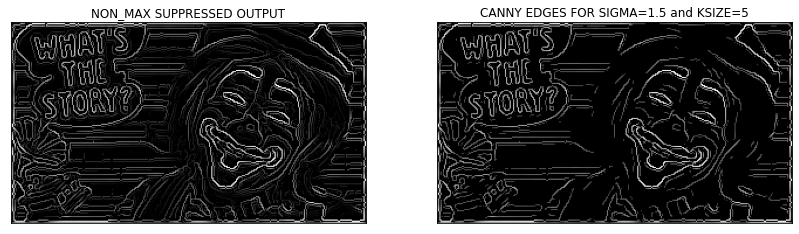

In [70]:
grad_mag, canny_op = canny(blur)

# PLOTTING THE IMAGE AFTER NON_MAX SUPPRESSION AND THE FINAL OUTPUT
# NOTE : I USED THE MEAN AS THE THRESHOLD
plt.figure(figsize=(14, 10))
plt.subplot(121), plt.imshow(grad_mag, cmap='Greys_r')
plt.title('NON_MAX SUPPRESSED OUTPUT'), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(canny_op, cmap='Greys_r')
plt.title('CANNY EDGES FOR SIGMA=1.5 and KSIZE=5'), plt.xticks([]), plt.yticks([])
plt.show()

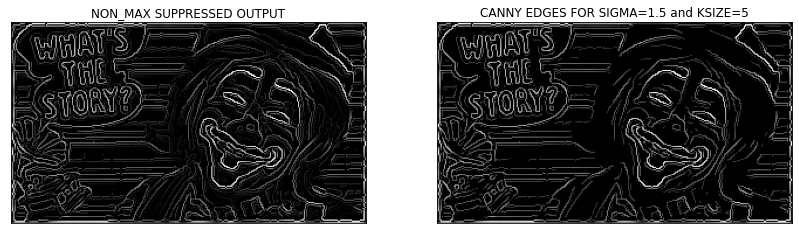

In [49]:
# OUTPUTS IN CASE MEDIAN IS USED 

- Repeating the above steps for **sigma = 3**

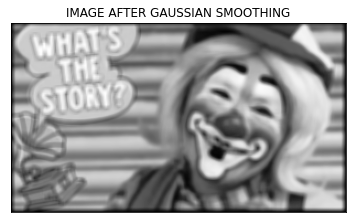

In [74]:
# Setting sigma to 3
blur = gaussian_Blur(grey, sigma=3)
plt.imshow(blur, cmap='Greys_r')
plt.title('IMAGE AFTER GAUSSIAN SMOOTHING'), plt.xticks([]), plt.yticks([])
plt.show()

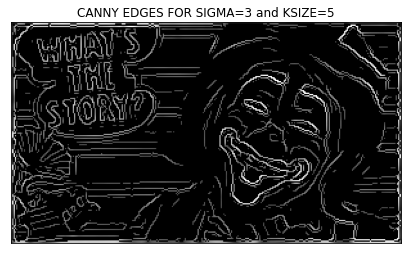

In [75]:
# Getting the non-max suppressed output and the final output
grad_mag, Canny = canny(blur)

plt.figure(figsize=(7, 5))
plt.imshow(Canny, cmap='Greys_r')
plt.title('CANNY EDGES FOR SIGMA=3 and KSIZE=5'), plt.xticks([]), plt.yticks([])
plt.show()

<h2 align=center> DIFFERENCES IN THE CANNY OUTPUT FOR DIFFERENT SIGMA</h2>

- The output for sigma = 3 detects the large scale edges but ignored the small scale edges (which can be clearly seen after the single-thresholding step).
- The output for sigma = 1.5 detects the finer edges too.
- You can observe this clearly in the clown's face where the finer edges are displayed for sigma = 1.5 but the dominant edges are more prominently displayed for sigma = 3.

<h1 align=center> R ADITHYA GOWTHAM | EE17B146</h1>